# Spike sorting

In [64]:
reAnalyse = False
engine = "dask" #"dask", "submitit", or None
GPU_available = False
preprocessed_folder = 'preprocessing'
sorter_folder='kilosort4_output_MB'
training_folder = 'sorting_analyzer_training_MB'
fullAnalyzer_folder = 'sorting_analyzer_full'
whitenFirst = True

## Set up everything
You shouldn't have to change anything from here so you can keep that part folded

### Load modules

In [2]:
import spikeinterface.full as si
from spikeinterface.sortingcomponents.motion import estimate_motion, interpolate_motion

import numpy as np
import pickle

import submitit
from memory_profiler import memory_usage
import time
import shutil
import os
from matplotlib import pyplot as plt

import asyncio
import gc

#import mbTools
from ipyfilechooser import FileChooser
import ipywidgets as widgets
from IPython.display import display
from IPython import get_ipython
import IPython
from IPython.display import Javascript
import pickleshare

from dask_jobqueue import SLURMCluster
from distributed import Client

%matplotlib widget

### Define a few variables

In [3]:
duration_extract = 1 #min

#### Structural (important for the process but no need to change)

In [4]:
last_job=None
sorter='kilosort4'

### Define a few functions

In [5]:
def magicretrieve(stored_var):
   # myvar will contain the variable previously stored with "%store test"
   myvar_filename = get_ipython().ipython_dir + '/profile_default/db/autorestore/' + stored_var
   with open(myvar_filename, 'rb') as f:
      return pickle.load(f)

def magicstore(stored_var, value):
   # myvar will contain the variable previously stored with "%store test"
   myvar_filename = get_ipython().ipython_dir + '/profile_default/db/autorestore/' + stored_var
   with open(myvar_filename, 'wb') as f:
      pickle.dump(value,f)      

In [6]:
def update_my_expe_choice(chooser):
    currentFile_data = str(chooser.selected)
    currentFile_mnt = os.path.join('/mnt/data/ahay',os.path.split(currentFile_data)[1])
    if not currentFile_data.startswith('/crnldata/'):
        print('please make sure to select the file on crnldata')
        return
    # check if the file already exists on /mnt/
    if os.path.isfile(currentFile_mnt):
        print(f"{currentFile_mnt} already exists")
    else:
        print(f"there is no version of {currentFile_data} on /mnt/")
        shouldCopy = False # it took a while (20 min for a file of about 150Gb)
        if shouldCopy:
            print(f'it will be copied to {currentFile_mnt}')
            startTime = time.time()
            shutil.copyfile(currentFile_data, currentFile_mnt)
            print(f'the transfer is complete, it took {time.time()-startTime} seconds')
        else:
            print('it can be transfered from here by changing the shouldCopy parameter but probably best not to because it takes a while and uses massive ressources')

    magicstore('currentFile_data', currentFile_data)
    magicstore('currentFile_mnt', currentFile_mnt)


def selectData(currentFile):
    print(currentFile)
    if currentFile is not None:
        pathName, fileName = os.path.split(currentFile)
    else:
        pathName = '/crnldata/waking/audrey_hay/'
        fileName = ''
    fc = FileChooser(path=pathName, filename=fileName, filter_pattern='NP_spikes_*.raw', select_default=True, show_only_dirs = False, title = "<b>Select file on crnldata</b>")
    display(fc)

    # Register callback function
    fc.register_callback(update_my_expe_choice)


In [7]:
async def runFunction(engine,funcName,*params,**engineParams):
    start_time = time.time()
    match engine:
        case "dask":
            print("dask")
            cluster = SLURMCluster(
                                **engineParams,
                                nanny=False,
                                log_directory="si_dask_logs",
                                scheduler_options={"dashboard_address": ":8780"} #port 8787 already used by jupyter
                                )
            cluster.scale(1)
            client = Client(cluster)

            print(client.get_versions(check=True))
    
            """
            from dask.distributed import PipInstall
            plugin = PipInstall(packages=["git+https://github.com/SpikeInterface/spikeinterface.git"], pip_options=["--upgrade"])
            client.register_plugin(plugin)
            plugin = PipInstall(packages=["git+https://github.com/SpikeInterface/probeinterface.git"], pip_options=["--upgrade"])
            client.register_plugin(plugin)
            plugin = PipInstall(packages=["git+https://github.com/SpikeInterface/spikeinterface-gui.git"], pip_options=["--upgrade"])
            client.register_plugin(plugin)
            plugin = PipInstall(packages=["kilosort"], pip_options=["--upgrade"])
            client.register_plugin(plugin)

            plugin = PipInstall(packages=["numpy"], pip_options=["--upgrade"])
            client.register_plugin(plugin)
            """
            
            print(cluster.job_script()) 

            future = client.submit(funcName, *params)
            res = future.result()
                        
            # Close cluster
            client.close()
            cluster.close()

        
        case "submitit":
            print("submitit")

            executor = submitit.AutoExecutor(folder=os.getcwd()+'/si_logs/')
            executor.update_parameters(**engineParams)

            job = executor.submit(funcName, *params)

            # print the ID of your job
            print("submit job" + str(job.job_id))  

            # await a single result
            await job.awaitable().results()
            res = job.result()

        case _:
            print("no engine")
            res = funcName(*params) 
            
    print(f"job done in {time.time()- start_time} s")
    return res

In [54]:
def GenerateDict(rec, folder, sorter_params):
    print(sorter_params)
    print(type(sorter_params))
    si.set_global_job_kwargs(n_jobs=40, progress_bar=True, chunk_duration="1s")
    sorting = si.run_sorter(sorter, rec, verbose=True, folder=folder, remove_existing_folder=True, **sorter_params)
    return sorting


In [63]:
def compute_analyzer(sorting,rec,folder,append=False):
    si.set_global_job_kwargs(n_jobs=40, progress_bar=True, chunk_duration="1s")
    
    if append:
        sorting_analyzer = si.load_sorting_analyzer(folder)
    else:
        sorting_analyzer = si.create_sorting_analyzer(sorting, rec, sparse=True, folder=folder,overwrite=True)

    sorting_analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
    sorting_analyzer.compute("waveforms")
    sorting_analyzer.compute("templates")
    sorting_analyzer.compute("noise_levels")
    sorting_analyzer.compute("unit_locations", method="monopolar_triangulation")
    sorting_analyzer.compute("isi_histograms")
    sorting_analyzer.compute("correlograms") #, window_ms=100, bin_ms=5.
    sorting_analyzer.compute("principal_components", n_components=3, mode='by_channel_global', whiten=True)
    sorting_analyzer.compute("quality_metrics", metric_names=["snr", "firing_rate"])
    sorting_analyzer.compute("template_similarity")
    sorting_analyzer.compute("spike_amplitudes")

    print(folder)
    print(sorting_analyzer)
    sorting_analyzer.save_as(folder=folder, format='binary_folder')
    print(sorting_analyzer)

    #return sorting_analyzer

In [10]:
def preprocess_traces(rec):
    # filter traces
    rec = rec.astype('float32')
    print("filtering trace, please wait")
    rec_filt = si.bandpass_filter(rec)
    display(rec_filt)

    # Account for the slight delays in recordings due to the fact the 384 channels are only digitilized with 32 ADCs
    print("aligning trace, please wait")
    isi=0.076923077
    inter_sample_shift = np.arange(12)*isi
    inter_sample_shift = np.expand_dims(np.repeat(inter_sample_shift,2),0)
    inter_sample_shift = np.repeat(inter_sample_shift,16,0).flatten()
    rec_filt_shifted = si.phase_shift(rec_filt, inter_sample_shift=inter_sample_shift)
    
    # Remove bad channels
    print("removing bad channels, please wait")
    try:
        bad_channel_ids, channel_labels = si.detect_bad_channels(rec_filt_shifted)
        print('bad_channel_ids', bad_channel_ids)
        rec = rec.remove_channels(bad_channel_ids)
        rec_filt = rec_filt.remove_channels(bad_channel_ids)
        rec_filt_shifted = rec_filt_shifted.remove_channels(bad_channel_ids)
    except Exception as error:
        print("could not remove bad channels because there was an error:")
        print(error)


    # Remove the common noisy events (artefacts)
    print("remove commonn ref, please wait")
    rec_filt_ref = si.common_reference(rec_filt_shifted)
    display(rec_filt_ref)

    recording_layers = dict(
        raw = rec,
        filter = rec_filt,
        realigned = rec_filt_shifted,
        cmr = rec_filt_ref,
    )

    return recording_layers, bad_channel_ids
    

In [61]:
def check_drift(rec):      
    
    job_kwargs_global = dict(n_jobs=40, progress_bar=True, chunk_duration="1s")
    si.set_global_job_kwargs(**job_kwargs_global)
    
    recording_corrected, motion, motion_info = si.correct_motion(
            rec, preset="dredge_fast", folder=None, output_motion=True, output_motion_info=True, estimate_motion_kwargs=dict(rigid=True)#,
        )
    return recording_corrected, motion, motion_info

In [12]:
def whiten(rec,recording_layers,layerName):

    rec_whitened = si.WhitenRecording(rec)

    recording_layers[layerName] = rec_whitened

    return recording_layers

In [13]:
def save_preprocessing(rec,foldername):
    return rec.save(folder=foldername, n_jobs=20, chunk_duration='1s', overwrite=True)


In [14]:
def checkRessources():
    # check node and CPU information
    print("### Node counts: \nA: currently in use \B available")
    !sinfo -o%A
    print("### CPU counts: \nA: core currently in use \nI: available \nO: unavailable (maintenance, down, etc) \nT: total")
    !sinfo -o%C
    !sinfo

    # check some stats of our last job
    if last_job is not None:
        print('### CPU time and MaxRSS of our last job (about 1000Mb should be added to your MaxRSS (Mb) in order to cover safely the memory needs of the python runtime)###')
        os.system(f'sacct -j {last_job.job_id} --format="CPUTime,MaxRSS"')

## Choose data

In [15]:

#currentFile_data = '/crnldata/waking/audrey_hay/NPX/NPX1/VB/Expe_2024-07-22_17-55-16/NP_spikes_2024-07-22T17_55_16.raw'
#mbTools.magicstore('currentFile_data', currentFile_data)
currentFile_data = magicretrieve('currentFile_data')
selectData(currentFile_data)

/crnldata/waking/audrey_hay/NPX/NPX1/VB/Expe_2024-07-22_17-55-16/NP_spikes_2024-07-22T17_55_16.raw


FileChooser(path='/crnldata/waking/audrey_hay/NPX/NPX1/VB/Expe_2024-07-22_17-55-16', filename='NP_spikes_2024-…

### Move data to /mnt/ if appropriate

In [16]:

shouldCopy = False # it took a while (20 min for a file of about 150Gb)
if shouldCopy:
    currentFile_data = magicretrieve('currentFile_data')
    currentFile_mnt = magicretrieve('currentFile_mnt')
    print(f'The file {currentFile_data} will be copied to {currentFile_mnt}')
    startTime = time.time()
    shutil.copyfile(currentFile_data, currentFile_mnt)
    print(f'the transfer is complete, it took {time.time()-startTime} seconds')
else:
    print('it can be transfered from here by changing the shouldCopy parameter but probably best not to because it takes a while and uses massive ressources')


it can be transfered from here by changing the shouldCopy parameter but probably best not to because it takes a while and uses massive ressources


### Lazy load data and probe

In [17]:
currentFile_data = magicretrieve('currentFile_data')
currentFile_mnt = magicretrieve('currentFile_mnt')

raw_rec = si.read_binary(currentFile_mnt, dtype='uint16', num_channels=384, sampling_frequency=30_000.,gain_to_uV=1, offset_to_uV=0)
raw_rec.annotate(raw_path = currentFile_data)
raw_rec = si.ScaleRecording(raw_rec, gain=-1)

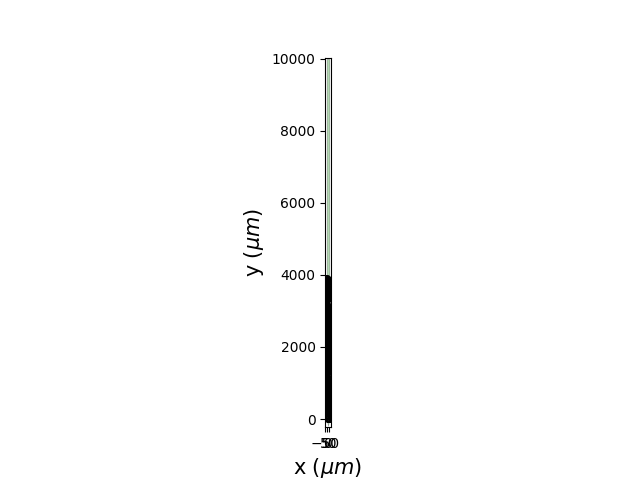

In [18]:
with open('/crnldata/waking/audrey_hay/NPX/NPXprobe.pkl', 'rb') as outp: 
    probe = pickle.load(outp)
probe.set_device_channel_indices(np.arange(384))

raw_rec = raw_rec.set_probe(probe)
display(si.plot_probe_map(raw_rec, with_channel_ids=True))

## PreProcessing

### Filter and apply common ref

In [19]:
if reAnalyse:
    match engine,GPU_available:
        case "dask", _: # no real interest in using gpu
            engineParam=dict(
                                queue='CPU',
                                cores=1,
                                memory="3GB",
                                worker_extra_args=["--lifetime", "2m"],
            )
        case "submitit", _:
            engineParam=dict(
                                mem_gb=3,
                                timeout_min=2,
                                slurm_partition="CPU",
                                cpus_per_task=4
            )
        case _:
            engineParam = dict()

    recording_layers, bad_channel_ids  = await runFunction(engine, preprocess_traces, raw_rec, **engineParam)
    
    print("computing done, please wait for display")
    si.plot_traces(recording_layers, backend='ipywidgets') #, mode='line'

dask


/home/audrey.hay/HayLabAnalysis/.si-env/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8780 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37041 instead
  warnings.warn(


{'scheduler': {'host': {'python': '3.11.2.final.0', 'python-bits': 64, 'OS': 'Linux', 'OS-release': '6.1.0-22-amd64', 'machine': 'x86_64', 'processor': '', 'byteorder': 'little', 'LC_ALL': 'None', 'LANG': 'fr_FR.UTF-8'}, 'packages': {'python': '3.11.2.final.0', 'dask': '2024.11.2', 'distributed': '2024.11.2', 'msgpack': '1.1.0', 'cloudpickle': '3.0.0', 'tornado': '6.4.1', 'toolz': '0.12.1', 'numpy': '1.26.3', 'pandas': '2.2.2', 'lz4': None}}, 'workers': {}, 'client': {'host': {'python': '3.11.2.final.0', 'python-bits': 64, 'OS': 'Linux', 'OS-release': '6.1.0-22-amd64', 'machine': 'x86_64', 'processor': '', 'byteorder': 'little', 'LC_ALL': 'None', 'LANG': 'fr_FR.UTF-8'}, 'packages': {'python': '3.11.2.final.0', 'dask': '2024.11.2', 'distributed': '2024.11.2', 'msgpack': '1.1.0', 'cloudpickle': '3.0.0', 'tornado': '6.4.1', 'toolz': '0.12.1', 'numpy': '1.26.3', 'pandas': '2.2.2', 'lz4': None}}}
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e si_dask_logs/dask-worker-%J.err
#SBATCH 

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Correct for motion

In [20]:
whitenFirst = True
canal_lim=300 #limitation of canals to keep for drift correction

In [21]:
if reAnalyse:
    probe_good = probe.get_slice(recording_layers["raw"].get_channel_ids())
    probe_2_correct = probe.get_slice([i for i in recording_layers["raw"].get_channel_ids() if i < canal_lim])

    if whitenFirst:
        recording_layers = whiten(recording_layers["cmr"],recording_layers,"whitenFirst")
        rec_2_correct = recording_layers["whitenFirst"]
    else:
        rec_2_correct = recording_layers["cmr"]

    rec_2_correct_short = rec_2_correct.channel_slice(probe_2_correct.device_channel_indices)
    display(rec_2_correct)


WhitenRecording: 383 channels - 30.0kHz - 1 segments - 189,418,428 samples 
                 6,313.95s (1.75 hours) - float32 dtype - 270.26 GiB

In [ ]:
if reAnalyse:
    match engine,GPU_available:
        case "dask", _:
            engineParam=dict(
                                queue='CPU',
                                cores=1,
                                memory="50GB",
                                job_cpu=55,
                                worker_extra_args=["--lifetime", "20m"],
            )
        case "submitit", _:
            engineParam=dict(
                                slurm_array_parallelism=4,
                                mem_gb=60,
                                timeout_min=20,
                                slurm_partition="CPU",
                                cpus_per_task=40
            )
        case _:
            engineParam = dict()

    recording_corrected_short, motion, motion_info  = await runFunction(engine,check_drift,rec_2_correct_short, **engineParam)

    recording_corrected = interpolate_motion(
                recording=rec_2_correct,
                motion=motion_info['motion'],
                **motion_info['parameters']['interpolate_motion_kwargs'])
    
    recording_layers["corrected"] = recording_corrected
    display(motion)

dask
{'scheduler': {'host': {'python': '3.11.2.final.0', 'python-bits': 64, 'OS': 'Linux', 'OS-release': '6.1.0-22-amd64', 'machine': 'x86_64', 'processor': '', 'byteorder': 'little', 'LC_ALL': 'None', 'LANG': 'fr_FR.UTF-8'}, 'packages': {'python': '3.11.2.final.0', 'dask': '2024.11.2', 'distributed': '2024.11.2', 'msgpack': '1.1.0', 'cloudpickle': '3.0.0', 'tornado': '6.4.1', 'toolz': '0.12.1', 'numpy': '1.26.3', 'pandas': '2.2.2', 'lz4': None}}, 'workers': {}, 'client': {'host': {'python': '3.11.2.final.0', 'python-bits': 64, 'OS': 'Linux', 'OS-release': '6.1.0-22-amd64', 'machine': 'x86_64', 'processor': '', 'byteorder': 'little', 'LC_ALL': 'None', 'LANG': 'fr_FR.UTF-8'}, 'packages': {'python': '3.11.2.final.0', 'dask': '2024.11.2', 'distributed': '2024.11.2', 'msgpack': '1.1.0', 'cloudpickle': '3.0.0', 'tornado': '6.4.1', 'toolz': '0.12.1', 'numpy': '1.26.3', 'pandas': '2.2.2', 'lz4': None}}}
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e si_dask_logs/dask-worker-%J.err
#SB

/home/audrey.hay/HayLabAnalysis/.si-env/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8780 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35745 instead
  warnings.warn(


job done in 584.4752173423767 s


Motion rigid - interval 1.0s - 1 segments

In [23]:
# (72) 16 min (slurm_array_parallelism=4, mem_gb=60, timeout_min=20, slurm_partition="CPU", cpus_per_task=40)
print("""rq: you should avoid submitting multiple small tasks with submitit, which would create many independent jobs
      and possibly overload the cluster, while you can do it without any problem through dask.distributed.""")

rq: you should avoid submitting multiple small tasks with submitit, which would create many independent jobs
      and possibly overload the cluster, while you can do it without any problem through dask.distributed.


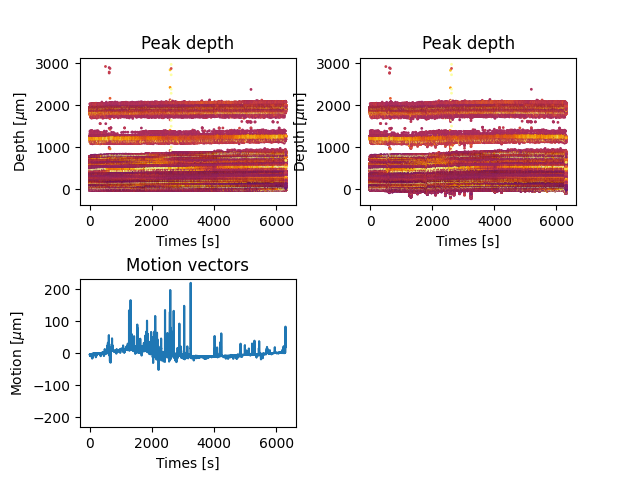

In [24]:
try:
    si.plot_motion_info(motion_info, recording_corrected,
                   color_amplitude=True,
        amplitude_cmap="inferno",)
except Exception as e:
    print(f"Could not plot motion: {e}. Possibly because you have to redo the analysis")

In [25]:
if reAnalyse and not whitenFirst:
    recording_layers = whiten(recording_corrected,recording_layers,"whitenLast")

In [26]:
try:
    si.plot_traces(recording_layers, backend='ipywidgets') #, mode='line'
except Exception as e:
    print(f"Could not plot traces: {e}. Possibly because you have to redo the analysis")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [32]:
if reAnalyse:
    if whitenFirst:
        rec = recording_layers["whitenFirst"] #if whitened and not corrected
        #rec = recording_layers["corrected"] #if whitened then corrected
    else:
        rec = recording_layers["whitenLast"] #if corrected the whiten
        
    match engine,GPU_available:
        case "dask", _: # real interest in using gpu ?
            engineParam=dict(
                                queue='CPU',
                                cores=1,
                                memory="15GB",
                                job_cpu=20,
                                worker_extra_args=["--lifetime", "1h"],
            )
        case "submitit", _:
            engineParam=dict(
                                mem_gb=3,
                                timeout_min=60,
                                slurm_partition="CPU",
                                cpus_per_task=4
            )
        case _:
            engineParam = dict()

    recording_saved  = await runFunction(engine, save_preprocessing, rec, preprocessed_folder, **engineParam)    
    display(recording_saved)
else:
    print(f"Trying to load preprocessed data")
    recording_saved = si.load_extractor(preprocessed_folder)
    display(recording_saved)

Trying to load preprocessed data


BinaryFolderRecording: 383 channels - 30.0kHz - 1 segments - 189,418,428 samples 
                       6,313.95s (1.75 hours) - float32 dtype - 270.26 GiB

## Identify spike clusters for the first few minutes of recording

It is good practice to have a look at available ressources and current use of the cluster

In [58]:
checkRessources()

#!sinfo --nodes=node15 -o "%50N  %10c  %20m  %30G "
!squeue --partition="GPU"

#torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 712.00 MiB. GPU 0 has a total capacity of 79.26 GiB of which 187.19 MiB is free. Process 1619368 has 77.78 GiB memory in use. Including non-PyTorch memory, this process has 1.28 GiB memory in use. Of the allocated memory 529.55 MiB is allocated by PyTorch, and 276.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


### Node counts: 
A: currently in use \B available
NODES(A/I)
6/13
### CPU counts: 
A: core currently in use 
I: available 
O: unavailable (maintenance, down, etc) 
T: total
CPUS(A/I/O/T)
34/862/144/1040
PARTITION   AVAIL  TIMELIMIT  NODES  STATE NODELIST
CPU*           up   infinite      1  drain node14
CPU*           up   infinite      5    mix node[13,15,18-20]
CPU*           up   infinite     11   idle node[1-11]
CPU*           up   infinite      1   down node21
INTERACTIVE    up   infinite      1  drain node12
INTERACTIVE    up   infinite      1    mix node17
INTERACTIVE    up   infinite      1   idle node16
GPU            up   infinite      1   idle node23
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [30]:

# for information, display a list of all parameters that can be modified for the sorter
params = si.get_default_sorter_params(sorter_name_or_class=sorter)
print(f"For information, parameters that are available for the sorter {sorter} are:\n", params)

For information, parameters that are available for the sorter kilosort4 are:
 {'batch_size': 60000, 'nblocks': 1, 'Th_universal': 9, 'Th_learned': 8, 'do_CAR': True, 'invert_sign': False, 'nt': 61, 'shift': None, 'scale': None, 'artifact_threshold': None, 'nskip': 25, 'whitening_range': 32, 'highpass_cutoff': 300, 'binning_depth': 5, 'sig_interp': 20, 'drift_smoothing': [0.5, 0.5, 0.5], 'nt0min': None, 'dmin': None, 'dminx': 32, 'min_template_size': 10, 'template_sizes': 5, 'nearest_chans': 10, 'nearest_templates': 100, 'max_channel_distance': None, 'templates_from_data': True, 'n_templates': 6, 'n_pcs': 6, 'Th_single_ch': 6, 'acg_threshold': 0.2, 'ccg_threshold': 0.25, 'cluster_downsampling': 20, 'cluster_pcs': 64, 'x_centers': None, 'duplicate_spike_ms': 0.25, 'scaleproc': None, 'save_preprocessed_copy': False, 'torch_device': 'auto', 'bad_channels': None, 'clear_cache': False, 'save_extra_vars': False, 'do_correction': True, 'keep_good_only': False, 'skip_kilosort_preprocessing': Fa

In [ ]:
if reAnalyse:
    rec_training = recording_saved.frame_slice(0, 30_000 * 60 * duration_extract)
    match engine,GPU_available:
        case "dask", False:
            engineParam=dict(
                                queue='CPU',
                                cores=1,
                                memory="6GB",
                                job_cpu=55,
                                worker_extra_args=["--lifetime", "2h"],
            )
        case "dask", True:
            engineParam=dict(
                                queue='GPU',
                                cores=1,
                                memory="4GB",
                                worker_extra_args=["--lifetime", "2h"],
                                job_extra_directives=['--gres=gpu:1g.20gb:1'],

            )                        
        case "submitit", False:
            engineParam=dict(
                                slurm_array_parallelism=4,
                                mem_gb=5,
                                timeout_min=120,
                                slurm_partition="CPU",
                                cpus_per_task=60
            )
        case "submitit", True:
            engineParam=dict(
                                mem_gb=5,
                                timeout_min=10,
                                slurm_partition="GPU",
                                cpus_per_task=2,
            )
        case _:
            engineParam = dict()

    sorter_params=dict(
        do_correction = False,
        skip_kilosort_preprocessing = True # we already did it
    )
    
    sorting  = await runFunction(engine, GenerateDict, rec_training, sorter_folder, sorter_params, **engineParam)   
    
    display(sorting)


dask
{'scheduler': {'host': {'python': '3.11.2.final.0', 'python-bits': 64, 'OS': 'Linux', 'OS-release': '6.1.0-22-amd64', 'machine': 'x86_64', 'processor': '', 'byteorder': 'little', 'LC_ALL': 'None', 'LANG': 'fr_FR.UTF-8'}, 'packages': {'python': '3.11.2.final.0', 'dask': '2024.11.2', 'distributed': '2024.11.2', 'msgpack': '1.1.0', 'cloudpickle': '3.0.0', 'tornado': '6.4.1', 'toolz': '0.12.1', 'numpy': '1.26.3', 'pandas': '2.2.2', 'lz4': None}}, 'workers': {}, 'client': {'host': {'python': '3.11.2.final.0', 'python-bits': 64, 'OS': 'Linux', 'OS-release': '6.1.0-22-amd64', 'machine': 'x86_64', 'processor': '', 'byteorder': 'little', 'LC_ALL': 'None', 'LANG': 'fr_FR.UTF-8'}, 'packages': {'python': '3.11.2.final.0', 'dask': '2024.11.2', 'distributed': '2024.11.2', 'msgpack': '1.1.0', 'cloudpickle': '3.0.0', 'tornado': '6.4.1', 'toolz': '0.12.1', 'numpy': '1.26.3', 'pandas': '2.2.2', 'lz4': None}}}
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e si_dask_logs/dask-worker-%J.err
#SB

/home/audrey.hay/HayLabAnalysis/.si-env/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8780 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43973 instead
  warnings.warn(


job done in 100.41612911224365 s


KiloSortSortingExtractor: 188 units - 1 segments - 30.0kHz

In [56]:
if not reAnalyse:
    if os.path.isdir(sorter_folder):
        # directory exists
        print(f"the previous folder {sorter_folder} was found, importing the data")
        sorting = si.read_sorter_folder(sorter_folder)
        display(sorting)
    else:
        print(f"the folder {sorter_folder} does not exist ; make sure of the path or reAnalyse the data")


## Cure the clusters
Here you should ensure that you are happy with the clusters that were found. For that, you should first compute analysis for the training clusters

### Fast initial curation

In [57]:
display(sorting)
sorting = si.remove_duplicated_spikes(sorting=sorting)
sorting = si.remove_excess_spikes(sorting=sorting, recording=recording_corrected)
#Est-ce qu'on veut aussi remove_redundant_units?
display(sorting)

KiloSortSortingExtractor: 188 units - 1 segments - 30.0kHz

RemoveDuplicatedSpikesSorting: 188 units - 1 segments - 30.0kHz

### Construct analyzer


In [ ]:
reAnalyse=True
if reAnalyse:
    match engine,GPU_available:
        case "dask", False:
            engineParam=dict(
                                queue='CPU',
                                cores=1,
                                memory="60GB",
                                job_cpu=40,
                                worker_extra_args=["--lifetime", "2h"],
            )
        case "dask", True:
            engineParam=dict(
                                queue='GPU',
                                cores=1,
                                memory="40GB",
                                worker_extra_args=["--lifetime", "2h"],
                                job_extra_directives=['--gres=gpu:1g.20gb:2'],

            )                        
        case "submitit", False:
            engineParam=dict(
                                slurm_array_parallelism=4,
                                mem_gb=5,
                                timeout_min=120,
                                slurm_partition="CPU",
                                cpus_per_task=60
            )
        case "submitit", True:
            engineParam=dict(
                                mem_gb=5,
                                timeout_min=10,
                                slurm_partition="GPU",
                                cpus_per_task=2,
            )
        case _:
            engineParam = dict()
    
    await runFunction(engine, compute_analyzer, sorting, rec_training, training_folder, **engineParam)    # add append=True to redo only a few analysis

dask
{'scheduler': {'host': {'python': '3.11.2.final.0', 'python-bits': 64, 'OS': 'Linux', 'OS-release': '6.1.0-22-amd64', 'machine': 'x86_64', 'processor': '', 'byteorder': 'little', 'LC_ALL': 'None', 'LANG': 'fr_FR.UTF-8'}, 'packages': {'python': '3.11.2.final.0', 'dask': '2024.11.2', 'distributed': '2024.11.2', 'msgpack': '1.1.0', 'cloudpickle': '3.0.0', 'tornado': '6.4.1', 'toolz': '0.12.1', 'numpy': '1.26.3', 'pandas': '2.2.2', 'lz4': None}}, 'workers': {}, 'client': {'host': {'python': '3.11.2.final.0', 'python-bits': 64, 'OS': 'Linux', 'OS-release': '6.1.0-22-amd64', 'machine': 'x86_64', 'processor': '', 'byteorder': 'little', 'LC_ALL': 'None', 'LANG': 'fr_FR.UTF-8'}, 'packages': {'python': '3.11.2.final.0', 'dask': '2024.11.2', 'distributed': '2024.11.2', 'msgpack': '1.1.0', 'cloudpickle': '3.0.0', 'tornado': '6.4.1', 'toolz': '0.12.1', 'numpy': '1.26.3', 'pandas': '2.2.2', 'lz4': None}}}
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e si_dask_logs/dask-worker-%J.err
#SB

/home/audrey.hay/HayLabAnalysis/.si-env/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8780 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34099 instead
  warnings.warn(


job done in 63.46920728683472 s


Now, you have 2 options:
- Either go back to local computer for full benefice of spikeinterface_gui
1. First, copy the sorting_analyzer_training folder to crnldata ([see next cell](#download))
1. Then, go on a local (not over ssh) script at [the most interactive viewing part](#local) at the end of this notebook, reload the sorting_analyzer older, and visualize everything on a gui.
1. Finally, when you are happy with the spike clusters, you can upload it back to the crnl cluster to proceed with [full sorting](#sort-full-recording)
- Or use [the following embedded plotting widgets](#widgets)

### Option1: go back to local PC
<a id='download'></a>

In [ ]:
# copy initial sorting to crnldata for viewing
if reAnalyse and engine=="dask":
    #it takes about 10s

    # takes about 10 minutes with dask
    cluster = SLURMCluster(cores=1,
                        memory="1GB",
                        job_cpu=1,
                        walltime="00:05:00",
                        log_directory="si_dask_logs",
                        nanny=False,
                        n_workers=1, # seems to divide ressources
                        scheduler_options={"dashboard_address": ":8780"} #port 8787 already used by jupyter
                        )
       
    cluster.scale(1)
    client = Client(cluster)

    src=training_folder
    currentFile_data = magicretrieve('currentFile_data')
    dst=os.path.join(os.path.split(currentFile_data)[0],src)
    start_time = time.time()
    future = client.submit(shutil.copytree, src, dst) 
    _ = future.result() 
    print(f"job done in {time.time()- start_time} s")

    # Close cluster
    client.close()
    cluster.close()

    display(sorting)

In [ ]:
cd /home/audrey.hay/HayLabAnalysis/python/sorting_analyzer_training
cd /
cd /mnt/data/ahay/
cd /crnldata/forgetting/Aurelie/Annie/tests_analyses_annie/

Commandes pour copier des dossiers

cp -r /home/audrey.hay/HayLabAnalysis/python/kilosort4_output /crnldata/forgetting/Aurelie/Annie/tests_analyses_annie/

cp -r /home/audrey.hay/HayLabAnalysis/python/sorting_analyzer_training /crnldata/forgetting/Aurelie/Annie/tests_analyses_annie/

In [ ]:
# copy initial sorting to crnldata for viewing
if reAnalyse and engine=="dask":
    #it takes about 10s

    # takes about 10 minutes with dask
    cluster = SLURMCluster(cores=1,
                        memory="1GB",
                        job_cpu=1,
                        walltime="00:05:00",
                        log_directory="si_dask_logs",
                        nanny=False,
                        n_workers=1, # seems to divide ressources
                        scheduler_options={"dashboard_address": ":8780"} #port 8787 already used by jupyter
                        )
       
    cluster.scale(1)
    client = Client(cluster)

    src=training_folder
    currentFile_data = '//10.69.168.1/crnldata/waking/audrey_hay/NPX/tests_analyses_annie/'
    dst=os.path.join(os.path.split(currentFile_data)[0],src)
    start_time = time.time()
    future = client.submit(shutil.copytree, src, dst) 
    _ = future.result() 
    print(f"job done in {time.time()- start_time} s")

    # Close cluster
    client.close()
    cluster.close()

    display(sorting)

**Here is when you should work locally**
and do the last part

... and then come back on ssh 

In [ ]:
#import back sorting_analyzer
# reAnalyse = True
if reAnalyse and engine=="dask":
    #it takes about 10s

    # takes about 10 minutes with dask
    cluster = SLURMCluster(cores=1,
                        memory="1GB",
                        job_cpu=1,
                        walltime="00:05:00",
                        log_directory="si_dask_logs",
                        nanny=False,
                        n_workers=1, # seems to divide ressources
                        scheduler_options={"dashboard_address": ":8780"} #port 8787 already used by jupyter
                        )
       
    cluster.scale(1)
    client = Client(cluster)

    dst=training_folder
    currentFile_data = magicretrieve('currentFile_data')
    src=os.path.join(os.path.split(currentFile_data)[0],dst)
    start_time = time.time()
    future = client.submit(shutil.copytree, src, dst) 
    _ = future.result() 
    print(f"job done in {time.time()- start_time} s")

    # Close cluster
    client.close()
    cluster.close()

    display(sorting)

In [ ]:
client.close()
cluster.close()

### Option2: inline visualisation
<a id='widgets'></a>

In [ ]:
sorting_analyzer_training = si.load_sorting_analyzer(training_folder)
display(sorting_analyzer_training)

In [ ]:
# select a few ids (unités)
#unit_ids=[1, 2, 5]
unit_ids=sorting_analyzer_training.unit_ids

In [ ]:
si.plot_unit_templates(sorting_analyzer_training, unit_ids=unit_ids, backend="ipywidgets")

In [ ]:
# select a few ids
unit_ids=[1, 2, 5]

In [ ]:
si.plot_rasters(sorting_analyzer_training, unit_ids=unit_ids)

In [ ]:
try:
    si.plot_isi_distribution(sorting_analyzer_training,unit_ids=unit_ids)
except Exception as error:
    print(error)

In [ ]:
si.plot_autocorrelograms(sorting_analyzer_training, unit_ids=unit_ids)

In [ ]:
si.plot_crosscorrelograms(sorting_analyzer_training, unit_ids=unit_ids)

In [ ]:
si.plot_unit_presence(sorting_analyzer_training)

## Sort full recording

In [ ]:
if reAnalyse and engine=="dask":
    gc.collect()
    
    if GPU_available: # takes about 10 minutes with dask
        cluster = SLURMCluster(
                        queue='GPU',
                        cores=1,
                        memory="70GB",
                        job_cpu=70,
                        walltime="20:00:00",
                        log_directory="si_dask_logs",
                        nanny=False,
                        n_workers=40, # seems to divide ressources
                        #worker_extra_args=["--resources GPU=2"],
                        job_extra_directives=['--gpus=2'],
                        scheduler_options={"dashboard_address": ":8780"} #port 8787 already used by jupyter
                        )
    else: # takes about 10 minutes
       cluster = SLURMCluster(
                        queue='CPU',
                        cores=1,
                        memory="6GB",
                        job_cpu=55,
                        walltime="02:00:00",
                        log_directory="si_dask_logs",
                        nanny=False,
                        n_workers=1, # seems to divide ressources
                        scheduler_options={"dashboard_address": ":8780"} #port 8787 already used by jupyter
                        )
       
    cluster.scale(1)
    client = Client(cluster)

    print(cluster.job_script()) 


    start_time = time.time()
    future = client.submit(compute_analyzer, sorting, recording_corrected, probe, fullAnalyzer_folder)
    future.result()
    #sorting_analyzer_training = future.results() 
    print(f"job done in {time.time()- start_time} s")

    # Close cluster
    client.close()
    cluster.close()

    #display(sorting_analyzer_training)

In [ ]:
start_time = time.time()
    future = client.submit(GenerateDict, rec_training, probe, sorter_folder, **sorter_params)
    sorting = future.result() 
    print(f"job done in {time.time()- start_time} s")

In [ ]:
if reAnalyse and engine=='submitit':
    start_time = time.time()

    executor = submitit.AutoExecutor(folder=os.getcwd()+'/si_logs/')
    #executor.update_parameters(slurm_array_parallelism=2, mem_gb=30, timeout_min=10, slurm_partition="CPU", cpus_per_task=50)
    executor.update_parameters(mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=70) #cpus_per_task

    # actually submit the job
    job = executor.submit(compute_analyzer, sorting, recording_corrected, probe, fullAnalyzer_folder)

    # print the ID of your job
    print("submit job" + str(job.job_id))  

    # await a single result
    await job.awaitable().results()
    print(f"job {job.job_id} completed in " + str(time.time()-start_time) + " seconds")

In [ ]:
#job 34074 completed in 408.1813361644745 second (slurm_array_parallelism=2, mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=50)
#job 34078 completed in 437.409494638443 seconds (slurm_array_parallelism=3, mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=50)
#job 34081 completed in 423.37460565567017 seconds (slurm_array_parallelism=2, mem_gb=60, timeout_min=20, slurm_partition="GPU", slurm_gres="gpu:2", cpus_per_task=50)
#job 34085 completed in 367.0000305175781 seconds (slurm_array_parallelism=2, mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=70)
#job 34089 completed in 370.1982145309448 seconds (slurm_array_parallelism=2, mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=80)
#job 34093 completed in 355.1876621246338 seconds (mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=70)

last_job = job
checkRessources()

In [ ]:
if not reAnalyse:
    print("not running analysis but loading previous one")
    sorting_analyzer = si.load_sorting_analyzer(fullAnalyzer_folder)
    display(sorting_analyzer)

In [ ]:
si.export_report(sorting_analyzer=sorting_analyzer,output_folder='report')

# Most interactive viewing on local
<a id='local'></a>

In [ ]:
#takes 13s
#from IPython.display import Javascript
#Javascript("Jupyter.notebook.execute_cell_range(0,15)")
#TODO: here should find a way to execute previous cell, or have the function in a loadable module.
currentFile_data = magicretrieve('currentFile_data')
print(currentFile_data)
sorting_analyzer_training = si.load_sorting_analyzer(os.path.join('//10.69.168.1',os.path.split(currentFile_data)[0],training_folder))
display(sorting_analyzer_training)

In [ ]:
%gui qt
si.plot_sorting_summary(sorting_analyzer_training, backend="spikeinterface_gui")

In [ ]:
client.close()
cluster.close()

In [ ]:
currentFile_data = magicretrieve('currentFile_data', storePath='')
print(currentFile_data)